# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method.

In [259]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [260]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [261]:
policy = np.ones((n_states, n_actions))/n_actions
print(policy)

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]


In [129]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions) 
assert np.allclose(np.sum(policy,axis=1), 1)
#assert的意思是，表达式n != 0应该是True，否则，根据程序运行的逻辑，后面的代码肯定会出错。
#如果断言失败，assert语句本身就会抛出AssertionError：

# Play the game

Just like before, but we also record all states and actions we took.

In [265]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(policy.shape[1], p=policy[s])   # <sample action from policy (hint: use np.random.choice)>
        
        new_s, r, done, info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states, actions, total_reward
        

In [266]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]

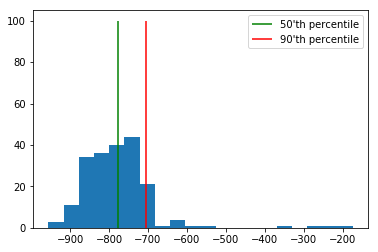

In [267]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps (2pts)

In [268]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)  #<Compute minimum reward for elite sessions. Hint: use np.percentile>
    #print(reward_threshold)
    
    
    elite_states = np.array(sum(np.array(states_batch)[np.where(rewards_batch >= reward_threshold)], []))
    elite_actions = np.array(sum(np.array(actions_batch)[np.where(rewards_batch >= reward_threshold)], []))
    
    #==========method 1=================
    #boolened = [i >= reward_threshold for i in rewards_batch ]
    #index = boolened.index(True)
    #elite_states = sum(states_batch[index:],[]) #<your code here>
    #elite_actions = actions_batch[index:]
    #elite_actions = [i for sub in elite_actions for i in sub ] #<your code here>
    #elite_states = np.array(elite_states)
    #elite_actions = np.array(elite_actions)
    # key: should flatten the list 
    
    #==============method 2==========
    #notice, the result should be array
    #boolened = [i >= reward_threshold for i in rewards_batch ]
    #elite_states = np.array(states_batch)[np.where(boolened)]
    #elite_states = np.array(sum(elite_states,[]))
    
    #elite_actions = np.array(actions_batch)[np.where(boolened)]
    #elite_actions = np.array(sum(elite_actions,[]))
     
    return elite_states,elite_actions
    

In [269]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [270]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    
    for i in range(len(elite_states)):
        s = elite_states[i]
        a = elite_actions[i]
       # print( i, 's=',s, ' a=', a)
        new_policy[s, a ] += 1
        
    #for j in range(len(elite_states)):
    summed = np.sum(new_policy, axis = 1)
    for i in range(n_states):
        if summed[i] != 0:
            new_policy[i, :] = new_policy[i, :]/summed[i]
        else:
            new_policy[i, :] = 1/n_actions
    
    #print(new_policy)
    
    return new_policy

In [271]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [272]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [273]:
#reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions 

mean reward = -3.600, threshold=-2.000


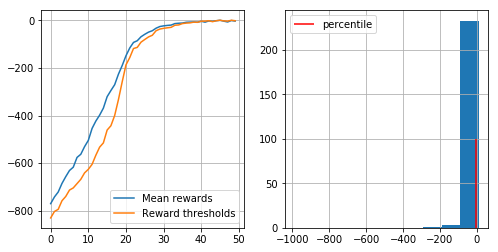

In [274]:
n_sessions = 250  #sample this many sessions
percentile = 25  #take this percent of session with highest rewards
learning_rate = 0.618  #add this thing to all counts for stability

log = []

for i in range(50):
    
    %time sessions = [ generate_session(policy) for i in range(n_sessions) ]#[<generate a list of n_sessions new sessions>]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards, percentile)  #<select elite states/actions>
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    
    #display results on chart
    show_progress(batch_rewards, log, percentile)

### Reflecting on results

You may have noticed that the taxi problem quickly converges from <-1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will siply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or  change the way you evaluate strategy (theoretically correct way). You can first sample an action for every possible state and then evaluate this choice of actions by running _several_ games and averaging rewards.

### Submit to coursera

In [238]:
from submit import submit_taxi
submit_taxi(generate_session, policy, "kouka.setsu@tcs.com", "YHAQQeuFlnj6FOO8")

Submitted to Coursera platform. See results on assignment page!
